# Food Vision



## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than write all of these, we can import a script and load them in from there.

The script we've got available can be found on GitHub: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [1]:
# Download helper function script
!python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


Saved under helper_functions.py


In [1]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

IF you want to get an overview of tensorflow datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [4]:
# Get Tensorflow datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets

datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True


In [6]:
# Load in the data (take 5-6 minutes in google colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                              split=['train','validation'], # what splits of data should we get? note: not all datasets have train, valid, test
                                              shuffle_files=False, # shuffle files on download?
                                              as_supervised = True, # download data in tuple format (sample, label), e.g. (image, label)
                                              with_info = True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data , we want to find:
* class names
* The datatype of our input data
* What the labels look like(e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names??

In [7]:
# Features of food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get the class names
class_names=ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [10]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form):{label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form):56
  Class name (str form): huevos_rancheros
  


In [12]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [13]:
# What are the min and max values?
import tensorflow as tf

tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

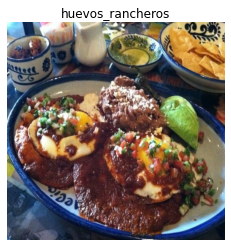

In [14]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

## Create Preprocessing functions for our data

Neural networks perform best when data is in a certain way(eg. batched, normalized, etc)

However, mot all data(including data from tensorflow datasets) come like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8 `data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* In `float32` data type (or for mixed precision `float16` and `float32`)
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
* Scaled (values between 0 & 1), also called normalized generally perform better.

With these points in mind , we've got a few things we can tackle with a preprocessing function

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we dont need to rescale our data(these architectures have rescaling built-in)

This means our functions need to:     
1. Reshape our image to all the same size
2. convert the dtype of our image tensor from `uint8` to `float32`

In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """

  image  = tf.image.resize(image, [img_shape,img_shape]) # reshape to img_shape
  # image=image/255. # scale image values (not required with EfficientNetBX models from tf,keras,applicationsS)
  return tf.cast(image,tf.float32), label # return (float32_image, label) tuple

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image,label)[0] # take only the image part, not the label

print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")


Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch and prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this, i'd highly recommend going through the following guide: https://www.tensorflow.org/guide/data_performance

In [17]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)



In [18]:
train_data, test_data


(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

This is like saying:: "Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

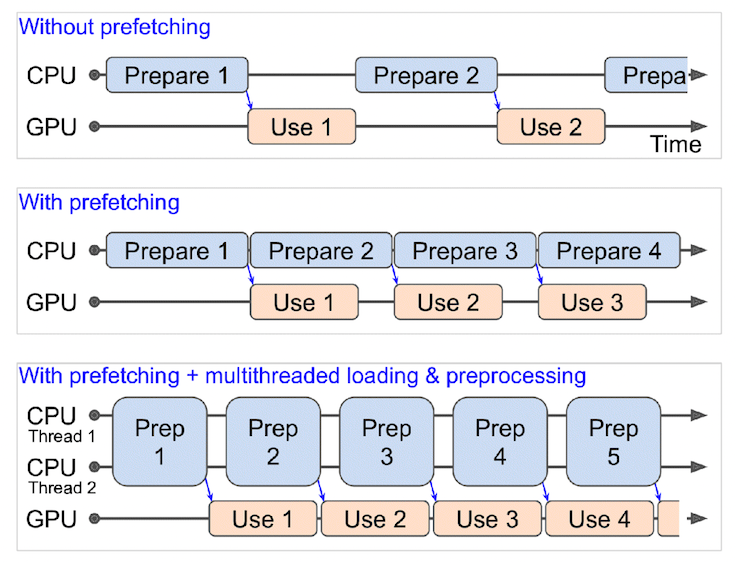

## Creating modeling callbacks

We're going too create a couple of callbacks to help us while our model trains

* TensorBoard callback to log training results(so we can visualize them later if need be)
* ModelCheckpoint callback to save our models progress after feature extraction

In [19]:
# Create a tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress

checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_acc', # save the model weights with best validation accuracy
                                                      sace_best_only=True,  # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

## Build feature extraction model

In [20]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create a functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])




In [21]:
len(class_names)

101

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Checking individual layers

In [23]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 False
global_average_pooling2d True
dense True
softmax_float32 True



Going through the above we see:

* `layer.name` (str) : a layer's human-readable name, can be defined by the name parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's trainable attribute to False
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in

In [24]:

# Check the layers in the base model]

for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False


## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model(train a couple outoput layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [25]:
# Fit feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=1,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                                            model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20211212-115743


C:\Users\a\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


2368/2368 [==============================] - 5418s 2s/step - loss: 1.8222 - accuracy: 0.5576 - val_loss: 1.2193 - val_accuracy: 0.6819


In [26]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 959s 1s/step - loss: 1.2295 - accuracy: 0.6787


[1.2295266389846802, 0.678732693195343]

## Save the whole model to file

In [27]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
drive = "/models/Food_vision_big"
model.save(drive)

INFO:tensorflow:Assets written to: /models/Food_vision_big\assets


INFO:tensorflow:Assets written to: /models/Food_vision_big\assets
C:\Users\a\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [28]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(drive)

In [29]:
# Check the layers in the base model
for layer in loaded_saved_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable)

input_1 True
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False


In [30]:
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 1154s 1s/step - loss: 1.2295 - accuracy: 0.6787


[1.2295266389846802, 0.678732693195343]

In [31]:

# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables
import numpy as np
np.isclose(results_loaded_saved_model,results_feature_extract_model)

array([ True,  True])

## Preparing our model's layers for fine-tuning

In [32]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
for layer in loaded_saved_model.layers[1].layers:
  layer.trainable = True
  print(layer.name, layer.trainable)

input_1 True
rescaling True
normalization True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
block2b_expand_activation True
block2b_dwconv True
block2b_bn True
block2b_activation True
block2b_se_squeeze True
block2b_se_reshape True
block2b_se_reduce True
block2b_se_expand True
block2b_se_excite True
block2b_project_conv True
block2b_project_bn True
block2b_drop True
bloc

In [33]:
# Keep only the last 5 layers of efficient net layers unfrozen
for layer in loaded_saved_model.layers[1].layers[:-5]:
  layer.trainable = False


In [34]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
# YOUR_CODE_HERE

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)





# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
# YOUR_CODE_HERE

model_checkpoint = tf.keras.callbacks.ModelCheckpoint("fine_tune_checkpoints/",
                                                      save_best_only=True,
                                                      monitor="val_loss")


# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [35]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
# YOUR_CODE_HERE
loaded_saved_model.compile(loss="sparse_categorical_crossentropy",
                        optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                        metrics=["accuracy"])



In [36]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
# YOUR_CODE_HERE

history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data,
                                                                  epochs=1,
                                                                  steps_per_epoch=len(train_data),
                                                                  validation_data=test_data,
                                                                  validation_steps=int(0.15*len(test_data)),
                                                                  callbacks=[create_tensorboard_callback("training_logs","efficientb0_101_classes_all_data_fine_tuning"),
                                                                             model_checkpoint,
                                                                             early_stopping,
                                                                             reduce_lr])  


Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20211212-163742
2368/2368 [==============================] - 5149s 2s/step - loss: 1.2691 - accuracy: 0.6796 - val_loss: 1.1728 - val_accuracy: 0.6986
INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets
C:\Users\a\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [37]:
# Save model locally 
loaded_saved_model.save("/models/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

INFO:tensorflow:Assets written to: /models/07_efficientnetb0_fine_tuned_101_classes_mixed_precision\assets


INFO:tensorflow:Assets written to: /models/07_efficientnetb0_fine_tuned_101_classes_mixed_precision\assets
C:\Users\a\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [38]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)


790/790 [==============================] - 1421s 2s/step - loss: 1.1798 - accuracy: 0.6932


## Evaluate your trained model

Used the notebook 06

In [39]:
# Making predictions with our trained model
pred_probs = loaded_saved_model.predict(test_data, verbose=1)

790/790 [==============================] - 1374s 2s/step


In [40]:
pred_probs

array([[2.5258996e-03, 6.7845387e-05, 2.2565437e-05, ..., 3.1015081e-03,
        5.4626906e-04, 1.4345782e-01],
       [4.1083194e-04, 1.2478611e-04, 6.4244244e-04, ..., 4.8830465e-04,
        1.1061743e-03, 6.1999261e-04],
       [1.1747259e-04, 2.1315238e-04, 2.2414447e-04, ..., 9.0564581e-06,
        3.3111827e-04, 2.4405632e-05],
       ...,
       [9.2597753e-02, 3.6839306e-04, 3.9762344e-05, ..., 5.6583801e-04,
        5.0127291e-04, 2.4292823e-02],
       [7.8320190e-05, 2.7638058e-07, 1.2769567e-05, ..., 3.6911379e-06,
        3.0161925e-06, 6.1686231e-05],
       [1.2314474e-02, 5.9750932e-04, 2.9512881e-03, ..., 1.1610430e-01,
        1.4869701e-03, 2.4785129e-03]], dtype=float32)

In [41]:
pred_classes = pred_probs.argmax(axis=1)

In [42]:
pred_classes

array([29, 81, 91, ..., 72, 31, 22], dtype=int64)

In [43]:
len(pred_classes)

25250

In [44]:
len(class_names)

101

In [45]:
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [46]:
test_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [47]:
y_labels = []

for image,label in test_data.unbatch():
  # images.append(image.numpy())
  y_labels.append(label.numpy())

y_labels[:10]
# images[:4]


[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [48]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy




0.6931881188118811

In [49]:
results_loaded_saved_model[1]

0.6931881308555603

In [50]:
from helper_functions import make_confusion_matrix


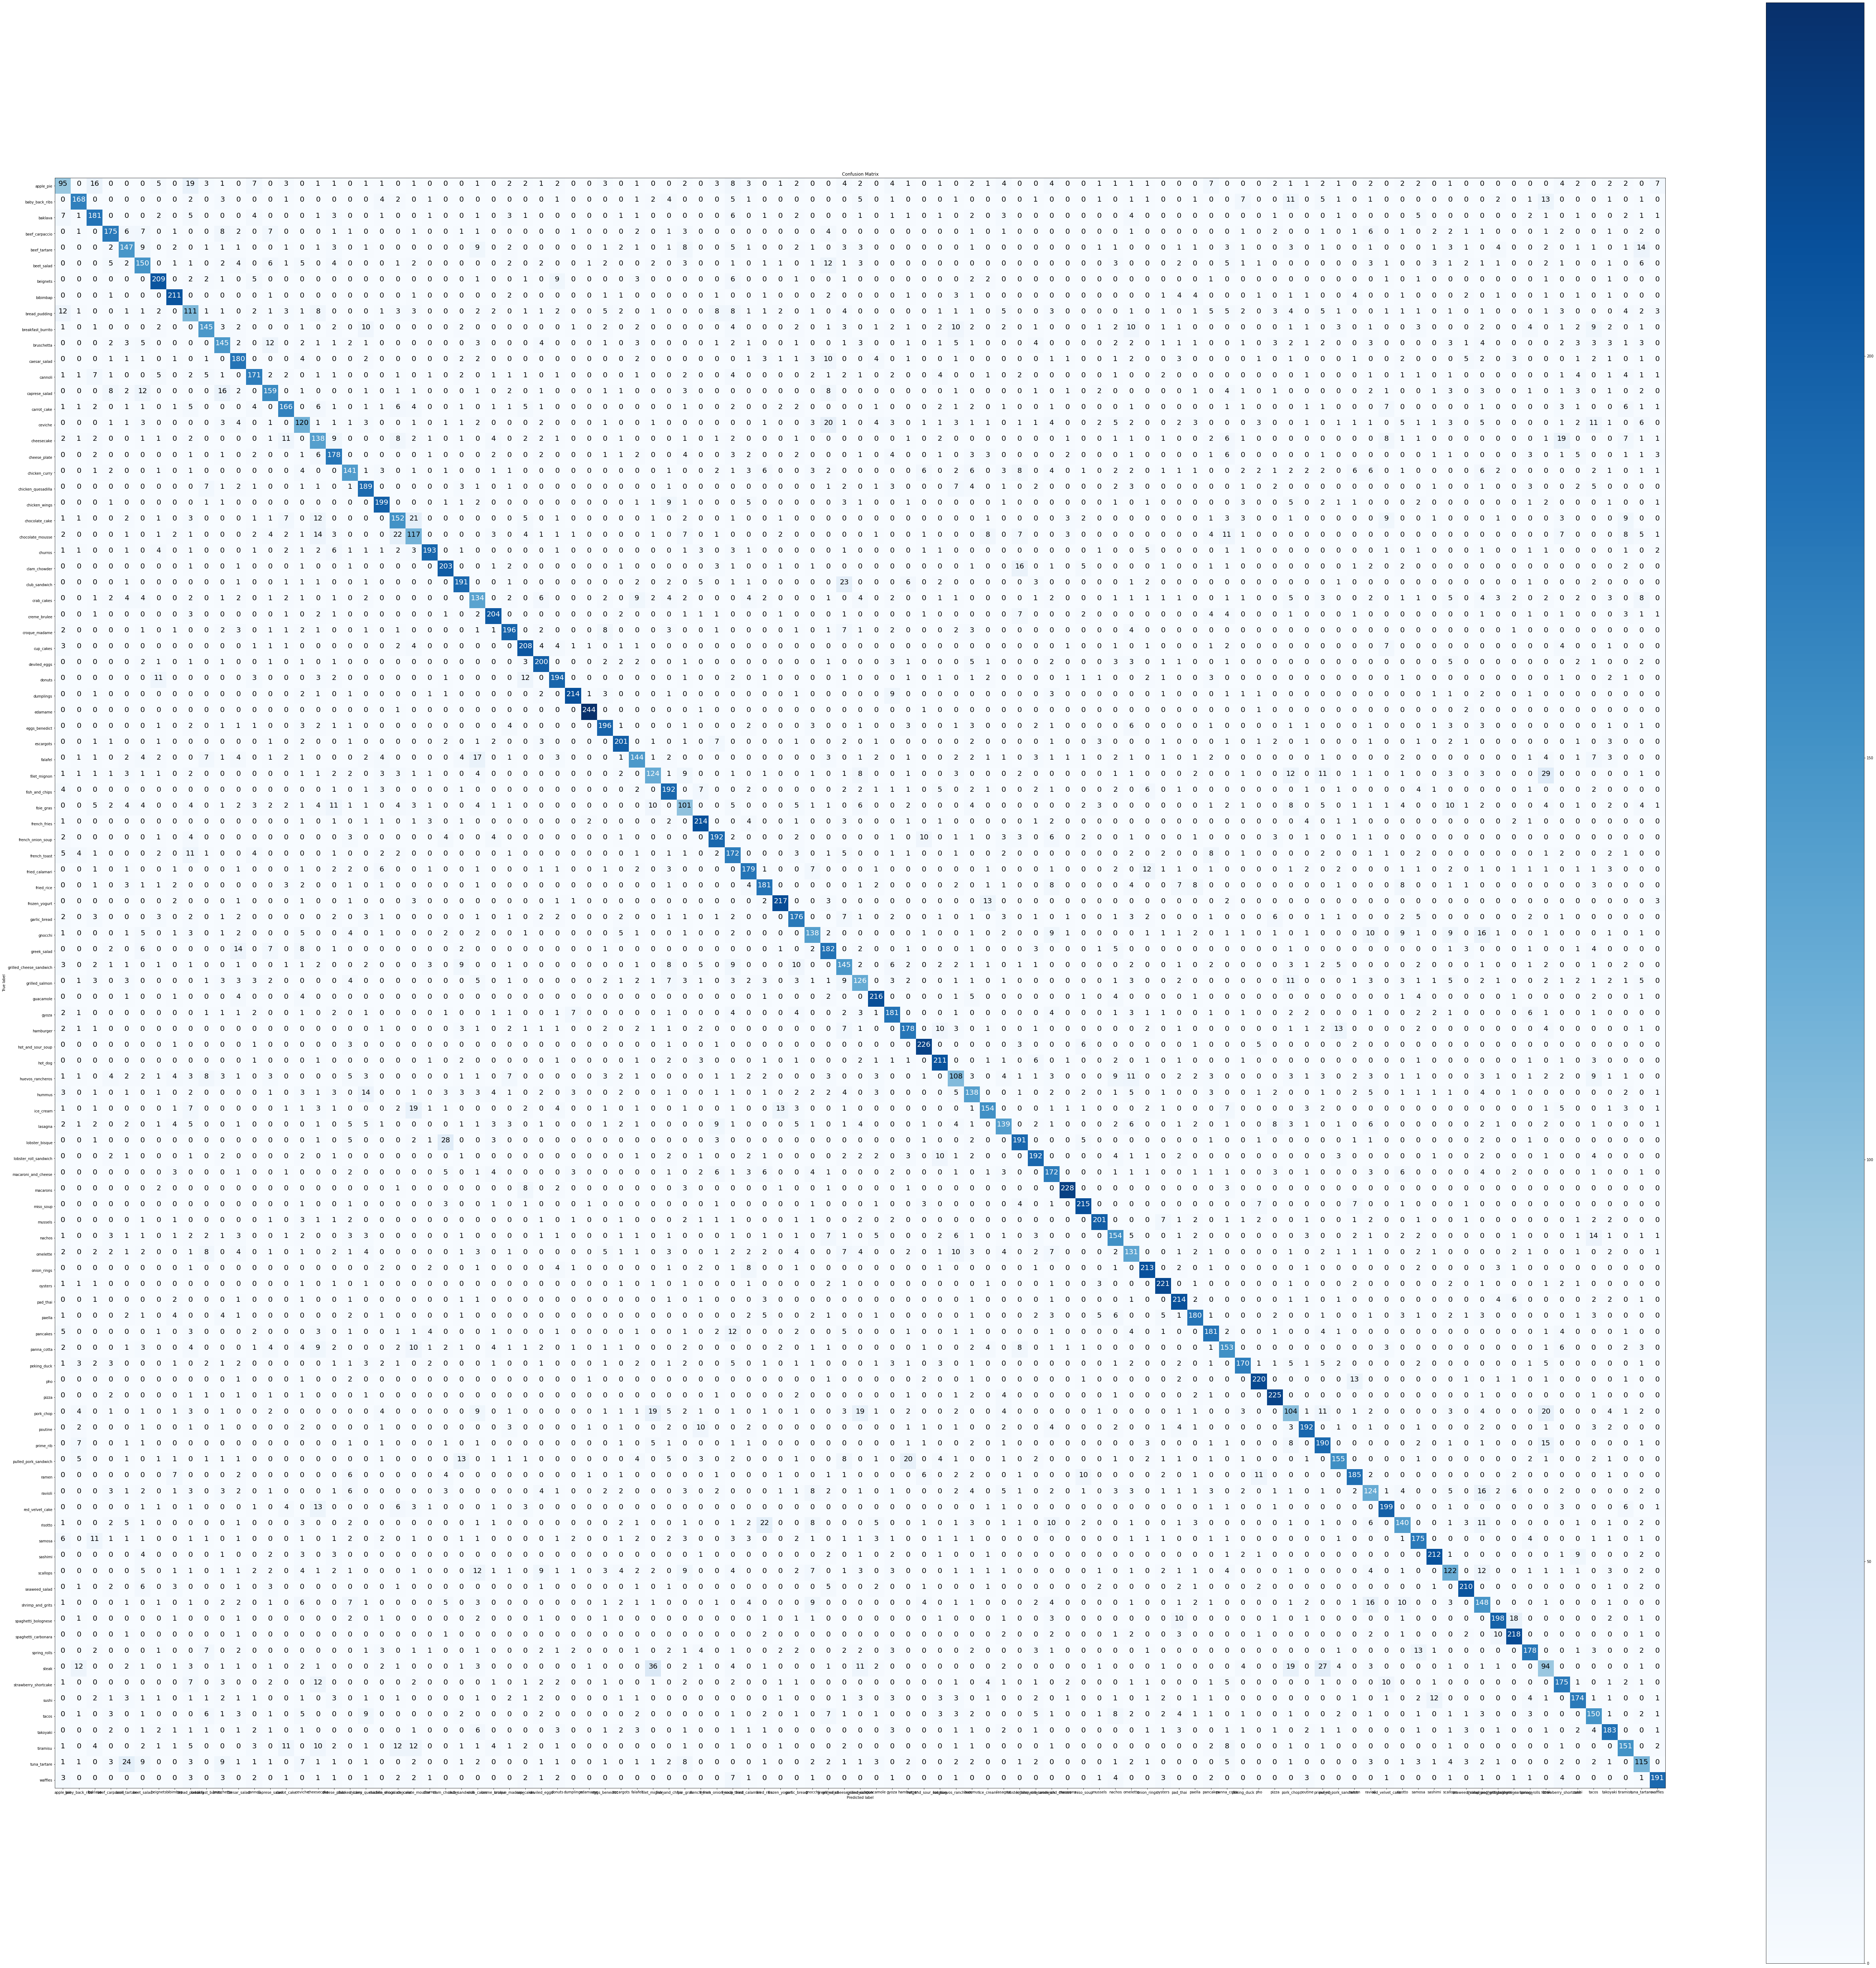

In [51]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.51      0.38      0.44       250
           1       0.75      0.67      0.71       250
           2       0.68      0.72      0.70       250
           3       0.72      0.70      0.71       250
           4       0.60      0.59      0.60       250
           5       0.56      0.60      0.58       250
           6       0.77      0.84      0.80       250
           7       0.79      0.84      0.82       250
           8       0.43      0.44      0.44       250
           9       0.68      0.58      0.62       250
          10       0.60      0.58      0.59       250
          11       0.64      0.72      0.68       250
          12       0.73      0.68      0.71       250
          13       0.66      0.64      0.65       250
          14       0.72      0.66      0.69       250
          15       0.50      0.48      0.49       250
          16       0.51      0.55      0.53       250
          17       0.66    

 Finding Wrong predictions

In [53]:
import pandas as pd

pred_df = pd.DataFrame({"actual_class": [class_names[i] for i in y_labels],
                        "predicted_class": [class_names[i] for i in pred_classes],
                        "pred_probability":pred_probs.max(axis=1)})

In [54]:
pred_df

,actual_class,predicted_class,pred_probability
0,cup_cakes,cup_cakes,0.300535
1,ramen,ramen,0.626693
2,spaghetti_carbonara,spaghetti_carbonara,0.804980
3,hamburger,hamburger,0.867128
4,takoyaki,takoyaki,0.824443
...,...,...,...
25245,fish_and_chips,fish_and_chips,0.958098
25246,sashimi,sashimi,0.959116
25247,pizza,pancakes,0.149657
25248,donuts,donuts,0.998827


In [55]:
pred_df['pred_correct'] = pred_df['actual_class'] == pred_df['predicted_class']
pred_df

,actual_class,predicted_class,pred_probability,pred_correct
0,cup_cakes,cup_cakes,0.300535,True
1,ramen,ramen,0.626693,True
2,spaghetti_carbonara,spaghetti_carbonara,0.804980,True
3,hamburger,hamburger,0.867128,True
4,takoyaki,takoyaki,0.824443,True
...,...,...,...,...
25245,fish_and_chips,fish_and_chips,0.958098,True
25246,sashimi,sashimi,0.959116,True
25247,pizza,pancakes,0.149657,False
25248,donuts,donuts,0.998827,True


In [56]:
top_100_wrong = pred_df[pred_df['pred_correct']== False].sort_values("pred_probability", ascending=False)[:100]

In [57]:
top_100_wrong

,actual_class,predicted_class,pred_probability,pred_correct
9735,scallops,deviled_eggs,0.988666,False
9895,carrot_cake,sushi,0.987261,False
13884,garlic_bread,bruschetta,0.981438,False
25131,paella,pad_thai,0.979019,False
22926,sashimi,sushi,0.977690,False
...,...,...,...,...
13343,dumplings,gyoza,0.880336,False
13474,poutine,croque_madame,0.879954,False
18371,fried_calamari,donuts,0.877249,False
6615,pancakes,churros,0.877072,False
